# Determine Road Curviness

## Overview

The Road Risk Prediction model uses a number of variables to predict the probability of a crash.  These include time of day, speed limit, road curviness, number of lanes, among other features.  I'd like to use Mapbox to allow a user to select an ad hoc route from a map display, add some menu selector to allow changing weather, time of day, and other inputs.  

One of the thorniest issues to resolve is how to find a proxy for a road's curviness, which is an input to the Road Risk Prediction model.  How to do this?

I've worked with [Mapbox](https://mapbox.com) on many of my projects in the past.  In addition to graphical maps, they also provide a wealth of data over their [Directions API](https://docs.mapbox.com/api/navigation/directions/).  Given origin and destination coordinates, it returns turn-by-turn directions between the two points in JSON format.  Within that data is a GeoJSON polyline that describes the path a vehicle would take along the route.  We'll use this polyline to calculate curviness.

If you'd like to run this Notebook, you'll need to sign up for a Mapbox account, and get a token.  The monthly free quotas have been generous enough that I've never been charged, despite frequent utilization during development and testing.  Before running this notebook, make sure you have an environment variable MAPBOX_TOKEN set to the value of your Mapbox token.

The first order of business is to get some representative routes to use as test cases.  As a first example, I chose directions from west Fort Worth to the DFW airport.  It's far from curvy.  For a curvy choice, I knew the Pikes Peak Highway was pretty darned twisty.  You can see for yourself on YouTube as a [driver breaks the time record.](https://youtu.be/Y20CLumT2Sg?si=H7XrIb4K-PnEvVfW)  Casting about for a third example, I discovered [Curvature](https://roadcurvature.com/), a sight that curates curvy roads for cyclists.  (It's true: there's something for everyone on the Internet.)  I chose an extremely twisy segment from a blog post on Curvature's site descibing a ["super-twisty road just off US 95"](https://roadcurvature.com/how-to-use/examples/idaho/) in Idaho.

First, let's install needed prerequisites..

In [1]:
!pip install geopandas kaggle


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import requests
import math

import geopandas as gpd

from flask import Flask, request, jsonify, Response

## Get Directions From Mapbox

Mapbox Directions API provides turn-by-turn directions between two locations.  In addition to the route's GeoJSON LineString geometry, the response includes data about the speed limit for each segment, what type of road it is, and other metadata.  

First, let's define a function to derive a location's (Universal Transverse Mercater)[https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system] (UTM) Coordinate Reference System (CRS).  These coordinate systems specify coordinates as northing and easting offsets from a reference coordinate.  It is used to measure distances/angles in meters and avoids increasing distortion at increasing latitudes.

In [3]:
# Return the Universal Transverse Mercater (UTM) Coordinate Reference System (CRS) for for the latitude 
# and longitude given.  UTM coordinate systems don't distort due to latitude
def get_utm_crs(lat, lng):
    if abs(lat) > 90.0:
        print(f"Not a valid latitude: {lat}!")
        return

    if abs(lng) > 180.0:
        print(f"Not a valid longitude: {lng}!")

    zone_is_south = lat < 0.0
    zone = math.ceil((lng + 180.0) / 6.0)

    crs = "+proj=utm +zone="
    crs = crs + str(zone)
    if lat < 0.0:
        crs = crs + " +south"

    crs = crs + " +datum=WGS84 +units=m +no_defs"

    return crs

Next, define a function to get the directions between two points from Mapbox, and return the raw response as well as a GeoPandas representation of the route.

In [4]:
import json
from shapely.geometry import shape

# We access the MAPBOX_TOKEN variable differently on Kaggle
def running_in_kaggle() -> bool:
    """
    Heuristics that are true in Kaggle notebooks:
    - Special directories exist (/kaggle/input, /kaggle/working)
    - Env var KAGGLE_KERNEL_RUN_TYPE is set
    - The kaggle_secrets module is available
    """
    try:
        if os.path.isdir("/kaggle/input") and os.path.isdir("/kaggle/working"):
            return True
        if "KAGGLE_KERNEL_RUN_TYPE" in os.environ:
            return True
        import kaggle_secrets  # noqa: F401  (only exists in Kaggle)
        return True
    except Exception:
        return False

def read_mapbox_directions(o_lat, o_lng, d_lat, d_lng):

    if running_in_kaggle():
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        mapbox_token = user_secrets.get_secret("MAPBOX_TOKEN")
    else:
        mapbox_token = os.environ['MAPBOX_TOKEN']
        
    url = f"https://api.mapbox.com/directions/v5/mapbox/driving/{o_lng}%2C{o_lat}%3B{d_lng}%2C{d_lat}?alternatives=false&annotations=maxspeed&geometries=geojson&language=en&overview=full&steps=true&access_token={mapbox_token}"

    # Store the full Directions response for further processing later.
    response = requests.get(url)
    mapbox_data = response.json()

    # Retrieve the GEOJSON portion of the directions, which describes every geographic point along the route.
    # Then, create a GeoDataFrame of the route, which will enable measuring changes in heading, or curviness.
    subdata = mapbox_data['routes'][0]['geometry']

    crs = get_utm_crs(o_lat, o_lng)
    geom = shape(subdata)
    geo_df = gpd.GeoDataFrame([1], geometry=[geom], crs="EPSG:4326")

    # Convert coordinates into local UTM so latitude isn't distorted
    geo_df = geo_df.to_crs(crs)

    return mapbox_data, geo_df

Now, get directions for routes in DFW, Pikes Peak Highway, and the ultra-twisty Idaho road.

In [5]:
dfw_data, dfw_df = read_mapbox_directions(32.759295, -97.503393, 32.903862, -96.973375)
pikes_data, pikes_df = read_mapbox_directions(38.900889, -104.973437, 38.840776, -105.043467)
idaho_data, idaho_df = read_mapbox_directions(45.817674, -116.251336, 45.81141, -116.258672)

## Display the Routes

Now that we've read the routes, let's take a look at them.  The numbers on the axes are the UTM northing and easting offsets.

DFW


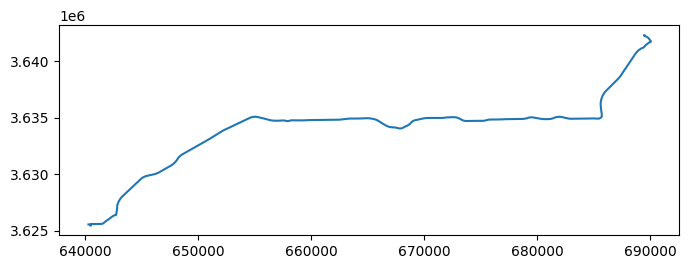

In [6]:
dfw_df.plot(figsize=(8,8))
print("DFW")

Pikes Peak Highway


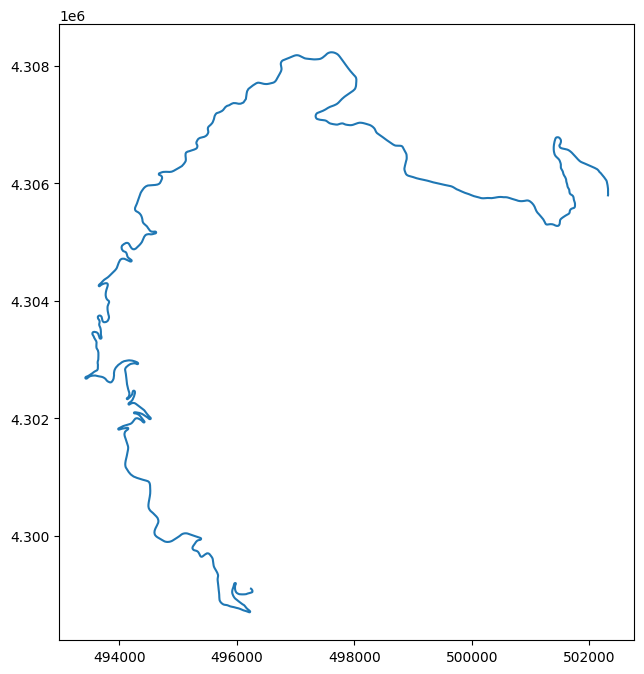

In [7]:
pikes_df.plot(figsize=(8,8))
print("Pikes Peak Highway")

Idaho


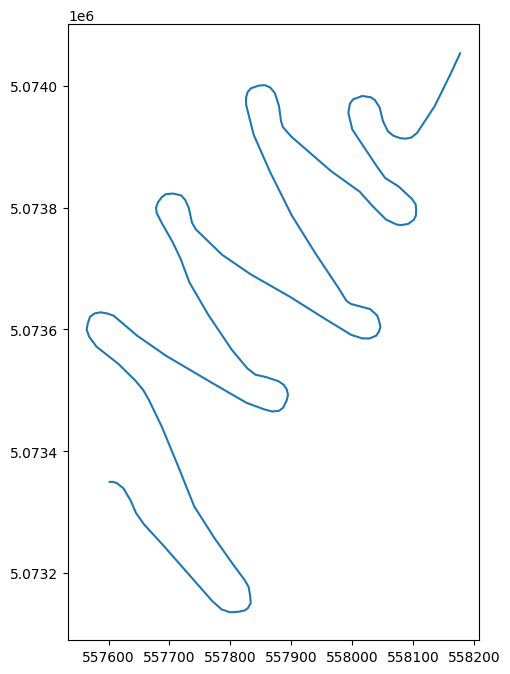

In [8]:
idaho_df.plot(figsize=(8,8))
print("Idaho")

## Determine Curviness

One way to measure curviness is to look at the angle (if any) desribed by three points.  To figure out the angle of the turn, we create two arrows from the middle point, then measure the angle between them.

In [9]:
import math
import numpy as np

def angle_p1p2p3(p1, p2, p3):
    v1 = np.array([p1[0] - p2[0], p1[1] - p2[1]], dtype=float)
    v2 = np.array([p3[0] - p2[0], p3[1] - p2[1]], dtype=float)

    n1 = np.linalg.norm(v1)
    n2 = np.linalg.norm(v2)
    if n1 == 0.0 or n2 == 0.0:
        return 0.0  # undefined; (perhaps use value of None instead?)
        
    # robust atan2 using cross and dot
    cross = v1[0]*v2[1] - v1[1]*v2[0]           # scalar "2D cross"
    dot   = float(np.dot(v1, v2))
    theta = math.degrees(math.atan2(abs(cross), dot))

    return theta


Next, let's define a function that iterates through all of a LineString's points, and calculates the angles to the successive points.  We'll use this to determine overall curviness.

In [10]:
import numpy as np
import pandas as pd

def calculate_linestring_curvature(linestring):
    """
    Calculates the curvature for each vertex of a Shapely LineString.
    Returns a list of curvature values. The first and last points
    have a curvature of 180 as they cannot form a triplet.
    """
    coords = np.array(linestring.coords)
    if len(coords) < 3:
        return [180] * len(coords)

    curvatures = [180]
    for i in range(1, len(coords) - 1):
        p1 = coords[i - 1]
        p2 = coords[i]
        p3 = coords[i + 1]

        ang = angle_p1p2p3(p1, p2, p3)

        curvatures.append(ang)

    curvatures.append(180)
    return curvatures


Now, apply the above function to each of the route GeoDataFrames, generating an array of turn values for each point.

In [11]:
dfw_curvs = dfw_df['geometry'].apply(calculate_linestring_curvature)
pikes_curvs = pikes_df['geometry'].apply(calculate_linestring_curvature)
idaho_curvs = idaho_df['geometry'].apply(calculate_linestring_curvature)

Create a Pandas Series for each so we can look at the statistical distribution of each.

In [12]:
dfw_curvs_ser = pd.Series(dfw_curvs[0])
pikes_curvs_ser = pd.Series(pikes_curvs[0])
idaho_curvs_ser = pd.Series(idaho_curvs[0])

In [13]:
dfw_curvs_ser.describe()

count    918.000000
mean     176.871130
std        9.267856
min       78.284917
25%      177.120815
50%      178.739521
75%      179.705563
max      180.000000
dtype: float64

In [14]:
pikes_curvs_ser.describe()

count    1189.000000
mean      169.543483
std         9.725958
min       125.837578
25%       165.382522
50%       172.547447
75%       176.620575
max       180.000000
dtype: float64

In [15]:
idaho_curvs_ser.describe()

count    134.000000
mean     164.459397
std        9.575669
min      145.145492
25%      156.401396
50%      164.212492
75%      173.290878
max      180.000000
dtype: float64

Looking at the means for these curve series, I think we've found a good proxy for curviness.  Straight ahead travel, or zero curve would have a measure of 180.0.  Lower values imply higher curviness.  Since the Idaho road example scored 164.459397, I'm guessing 160.0 would be a good "maximally curvy" value.  So, we can use 180.0 as a 0 curve score, 160 or anything lower a 1.0, and scale for values between.

Pulling everything together:

In [16]:
def calculate_curviness(geo_df):
    geo_curvs = geo_df['geometry'].apply(calculate_linestring_curvature)
    geo_curvs_ser = pd.Series(geo_curvs[0])
    raw_curviness = geo_curvs_ser.mean()

    raw_curviness = max(raw_curviness, 160.0)
    curviness = (180.0 - raw_curviness) / (180.0 - 160.0)

    return curviness

In [17]:
# Testing...

print("DFW route curviness        :",  calculate_curviness(dfw_df))
print("Pike's Peak route curviness:",  calculate_curviness(pikes_df))
print("Idaho route curviness      :",  calculate_curviness(idaho_df))

DFW route curviness        : 0.15644351185875394
Pike's Peak route curviness: 0.5228258340782943
Idaho route curviness      : 0.7770301326379382


If you've been looking for real-world application of a Road Risk Prediction model, I hope you'll find this notebook useful.  Happy coding!

In [21]:
dir(dfw_df)

['T',
 '_AXIS_LEN',
 '_AXIS_ORDERS',
 '_AXIS_TO_AXIS_NUMBER',
 '_HANDLED_TYPES',
 '__abs__',
 '__add__',
 '__and__',
 '__annotations__',
 '__array__',
 '__array_priority__',
 '__array_ufunc__',
 '__arrow_c_stream__',
 '__bool__',
 '__class__',
 '__contains__',
 '__copy__',
 '__dataframe__',
 '__dataframe_consortium_standard__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__finalize__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__geo_interface__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pandas_priority__',
 '__pos